**Stage**: Model Performance Analysis

**Objectives**:
- Visualize predictions and residuals to assess model accuracy.
- Evaluate linear regression model performance (with/without outliers) using RMSE, MAE, and R².
- Analyze the impact of outliers on model performance.

---

In [1]:
# Parameters for automation
stock_symbol = None  # e.g., 'TSLA'
fetch_id = None  # e.g., 'fetch_20250617_093553'
config_path = "config/config.json"

## Data Source and Preparation
The analysis uses processed stock data from `data/processed/processed_{stock_symbol.lower()}_data.csv`, which includes 250 days of historical data with engineered features such as `prev_close`, `volume`, `ma5`, and `next_close`. This data was prepared using `process_data.py`.

In [2]:
import os
import json
import pandas as pd
import joblib
import logging
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any, Optional
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from spp.data_utils import load_config, load_data, extract_timestamp
from spp.logging_utils import setup_logging
from spp.plot_utils import plot_predictions, plot_residuals
from IPython.display import Markdown, display

# Define project root directory
config = load_config(config_path="config/config.json", logger=setup_logging(logger_name="model_analysis", log_dir="logs"))
PROJECT_ROOT = config["project_root"]

# Initialize logger
logger = setup_logging(logger_name="model_analysis", log_dir="logs")


def load_models(
    stock_symbol: str, 
    timestamp: str, 
    models_dir: str, 
    project_root: str
) -> Tuple[Any, Optional[Any]]:
    """Load pre-trained models for stock price prediction with and without outliers."""
    model_with_path = os.path.join(project_root, models_dir, f"model_{stock_symbol.lower()}_{timestamp}_with_outliers.pkl")
    model_without_path = os.path.join(project_root, models_dir, f"model_{stock_symbol.lower()}_{timestamp}_without_outliers.pkl")
    
    logger.info(f"Checking model with outliers: {os.path.abspath(model_with_path)}")
    if not os.path.exists(model_with_path):
        logger.error(f"Model file not found: {model_with_path}")
        raise FileNotFoundError(f"Model file not found: {model_with_path}")
    model_with_outliers = joblib.load(model_with_path)
    logger.info(f"Successfully loaded model with outliers from {model_with_path}")
    
    model_without_outliers = None
    logger.info(f"Checking model without outliers: {os.path.abspath(model_without_path)}")
    if os.path.exists(model_without_path):
        model_without_outliers = joblib.load(model_without_path)
        logger.info(f"Successfully loaded model without outliers from {model_without_path}")
    else:
        logger.warning(f"Model without outliers not found at {model_without_path}. Falling back to model with outliers.")
    
    return model_with_outliers, model_without_outliers


def prepare_data(
    df: pd.DataFrame, 
    include_outliers: bool = True
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare feature and target data from a DataFrame for modeling.

    Parameters:
        df : pd.DataFrame
            Input DataFrame containing financial data with columns:
            - 'prev_close': Previous closing price
            - 'volume': Trading volume
            - 'ma5': 5-day moving average
            - 'next_close': Target variable (next closing price)
            - 'is_outlier' (optional): Boolean indicator for outliers
        include_outliers : bool, optional (default=True)
            If False, filters out rows marked as outliers if 'is_outlier' column exists.

    Returns
        Tuple[pd.DataFrame, pd.Series]
            - X: DataFrame containing feature columns ['prev_close', 'volume', 'ma5']
            - Y: Series containing the target variable 'next_close'
    """
    if not include_outliers:
        if 'is_outlier' in df.columns:
            df = df[df['is_outlier'] == False]
        else:
            logger.warning("No 'is_outlier' column found. Proceeding without filtering.")
    X = df[['prev_close', 'volume', 'ma5']]
    Y = df['next_close']
    return X, Y


def evaluate_model(
    Y_true: pd.Series, 
    Y_pred: pd.Series
) -> Dict[str, float]:
    """Evaluate the performance of a model using RMSE, MAE, and R² metrics.

    Args:
        Y_true (pd.Series): The true target values.
        Y_pred (pd.Series): The predicted target values.

    Returns:
        Dict[str, float]: A dictionary containing the RMSE, MAE, and R² scores.
    """
    rmse = root_mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    r2 = r2_score(Y_true, Y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


def generate_summary(
    metrics_with: Dict[str, float],
    metrics_without: Dict[str, float],
    outlier_impact: str
) -> str:
    """Generate a formatted summary string of model performance metrics and outlier impact."""
    summary = f"""
- **Model with Outliers**:
  - RMSE: {metrics_with['RMSE']:.2f}
  - MAE: {metrics_with['MAE']:.2f}
  - R²: {metrics_with['R2']:.2f}
"""
    if metrics_without != metrics_with:
        summary += f"""\n
- **Model without Outliers**:
  - RMSE: {metrics_without['RMSE']:.2f}
  - MAE: {metrics_without['MAE']:.2f}
  - R²: {metrics_without['R2']:.2f}
"""
    else:
        summary += "\n- **Model without Outliers**: Not available (used model with outliers)."
    summary += f"""\n
- **Outlier Impact**:
  - {outlier_impact}
    """
    return summary.strip()
    

Logger 'model_analysis' has been set up with log level INFO
Successfully loaded config file from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/config/config.json
Config keys: current_fetch, current_models, fetch_id, project_root, utils_dir, log_dir, plots_dir, models_dir, raw_data_dir, processed_data_dir, gaps_dir, outliers_dir, docs_data_eval_dir, docs_model_eval_dir
Logger 'model_analysis' has been set up with log level INFO


In [3]:
def main(
    stock_symbol=None, 
    fetch_id=None, 
    config_path=os.path.join(PROJECT_ROOT, "config", "config.json")
) -> None:
    """Analyze stock price prediction models with and without outliers.

    This function serves as the primary workflow for analyzing stock price prediction models.

    Args:
        stock_symbol (str, optional): The stock symbol to analyze (e.g., 'TSLA'). If not provided, defaults to the value in the config under 'current_fetch.stock_symbol'.
        fetch_id (str, optional): The identifier for the data fetch (e.g., 'fetch_20250617_093553'). If not provided, defaults to the value in the config under 'current_fetch.fetch_id'.
        config_path (str, optional): Path to the configuration file. Defaults to 'config/config.json' relative to the project root (constructed via `os.path.join(PROJECT_ROOT, "config", "config.json")`).

    Returns:
        None: This function does not return a value but performs actions such as logging, plotting, and printing.
    """
    config = load_config(config_path, logger=logger)
    stock_symbol = stock_symbol or config.get("current_fetch", {}).get("stock_symbol", "TSLA")
    fetch_id = fetch_id or config.get("current_fetch", {}).get("fetch_id")
    model_id_with_outliers = config.get("current_models", {}).get("with_outliers")
    
    if model_id_with_outliers:
        try:
            timestamp = extract_timestamp(model_id_with_outliers)
        except ValueError as e:
            timestamp = "unknown"
            logger.error(f"Failed to extract timestamp from model ID: {e}")
    else:
        timestamp = "unknown"
        logger.error("No model ID found for 'with_outliers' in config")
    logger.info(f"Analyzing stock: {stock_symbol}, Fetch ID: {fetch_id}, Timestamp: {timestamp}")
    
    # Data preparation
    df = load_data(config, stock_symbol, fetch_id, data_type="processed", logger=logger)
    X_with, Y_with = prepare_data(df, include_outliers=True)
    X_without, Y_without = prepare_data(df, include_outliers=False)
    X_train_with, X_test_with, Y_train_with, Y_test_with = train_test_split(X_with, Y_with, test_size=0.2, shuffle=False)
    X_train_without, X_test_without, Y_train_without, Y_test_without = train_test_split(X_without, Y_without, test_size=0.2, shuffle=False)

    # Load models and generate predictions
    try:
        model_with, model_without = load_models(stock_symbol, timestamp, config["models_dir"], PROJECT_ROOT)
    except FileNotFoundError as e:
        logger.error(f"Failed to load models: {e}")
        raise
    
    if model_without is None:
        model_without = model_with  # Fallback
        Y_test_without = Y_test_with  # Use same test set for consistency
        X_test_without = X_test_with
    
    Y_pred_with = model_with.predict(X_test_with)
    Y_pred_without = model_without.predict(X_test_without)

    # Evaluate models
    metrics_with = evaluate_model(Y_test_with, Y_pred_with)
    metrics_without = evaluate_model(Y_test_without, Y_pred_without)

    # Visualize
    plot_predictions(Y_test_with, pd.Series(Y_pred_with, index=Y_test_with.index), stock_symbol, timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    if model_without != model_with:  # Only plot separate if different
        plot_predictions(Y_test_without, pd.Series(Y_pred_without, index=Y_test_without.index), f"{stock_symbol}_no_outliers", timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    plot_residuals(Y_test_with, Y_pred_with, "With Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    if model_without != model_with:
        plot_residuals(Y_test_without, Y_pred_without, "Without Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    else:
        logger.info("No separate model without outliers; skipping duplicate plots.")

    # Outlier analysis
    outlier_date = '2025-06-05'
    if outlier_date in df.index:
        X_outlier = df.loc[[outlier_date], ['prev_close', 'volume', 'ma5']]
        Y_outlier_actual = df.loc[outlier_date, 'next_close']
        Y_outlier_pred_with = model_with.predict(X_outlier)[0]
        Y_outlier_pred_without = model_without.predict(X_outlier)[0] if model_without is not None else Y_outlier_pred_with
        error_with = abs(Y_outlier_actual - Y_outlier_pred_with)
        error_without = abs(Y_outlier_actual - Y_outlier_pred_without)
        outlier_impact = f"Error with outliers: {error_with:.2f}, Error without outliers: {error_without:.2f}"
        if model_without is None:
            outlier_impact += " (No separate model without outliers; used model with outliers for both.)"
    else:
        outlier_impact = "Outlier date not found in data."

    # Generate summary
    summary = generate_summary(metrics_with, metrics_without, outlier_impact)
    if model_without is None:
        summary += "\n\n**Note**: No model without outliers was generated (likely no outliers detected), so the 'without outliers' metrics and predictions are identical to 'with outliers'."
    display(Markdown(summary))

In [4]:
# Load config
config = load_config(config_path, logger=logger)
stock_symbol = stock_symbol or config.get("current_fetch", {}).get("stock_symbol", "TSLA")
fetch_id = fetch_id or config.get("current_fetch", {}).get("fetch_id")

# Extract timestamp from the model ID in config.json
model_id_with_outliers = config.get("current_models", {}).get("with_outliers")
logger.info(f"Retrieved model ID: {model_id_with_outliers}")
if model_id_with_outliers:
    try:
        timestamp = extract_timestamp(model_id_with_outliers)
    except ValueError as e:
        timestamp = "unknown"
        logger.error(f"Failed to extract timestamp from model ID: {e}")
else:
    timestamp = "unknown"
    logger.error("No model ID found for 'with_outliers' in config")
logger.info(f"Analyzing stock: {stock_symbol}, Fetch ID: {fetch_id}, Timestamp: {timestamp}")

Successfully loaded config file from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/config/config.json
Config keys: current_fetch, current_models, fetch_id, project_root, utils_dir, log_dir, plots_dir, models_dir, raw_data_dir, processed_data_dir, gaps_dir, outliers_dir, docs_data_eval_dir, docs_model_eval_dir
Retrieved model ID: model_tsla_20250813_092406_with_outliers
Analyzing stock: TSLA, Fetch ID: fetch_20250813_092351, Timestamp: 20250813_092406


In [5]:
# Load and prepare data
df = load_data(config, stock_symbol, fetch_id, data_type="processed", logger=logger)

# Prepare data with outliers
X_with, Y_with = prepare_data(df, include_outliers=True)
X_train_with, X_test_with, Y_train_with, Y_test_with = train_test_split(X_with, Y_with, test_size=0.2, shuffle=False)

# Prepare data without outliers
X_without, Y_without = prepare_data(df, include_outliers=False)
X_train_without, X_test_without, Y_train_without, Y_test_without = train_test_split(X_without, Y_without, test_size=0.2, shuffle=False)

Loaded processed data from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/processed/processed_tsla_fetch_20250813_092351.csv with 250 rows


In [6]:
# Load models and generate predictions
models_dir = config["models_dir"]
project_root = config["project_root"]
try:
    model_with, model_without = load_models(stock_symbol, timestamp, models_dir, project_root)
except FileNotFoundError as e:
    logger.error(f"Failed to load models: {e}")
    raise

# Generate predictions
Y_pred_with = model_with.predict(X_test_with)
logger.info("Generated predictions for model with outliers.")
Y_pred_without = None
if model_without is not None:
    Y_pred_without = model_without.predict(X_test_without)
    logger.info("Generated predictions for model without outliers.")
else:
    logger.warning("No model without outliers available; using model with outliers for both.")
    Y_pred_without = Y_pred_with  # Fallback
    X_test_without = X_test_with
    Y_test_without = Y_test_with

Checking model with outliers: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250813_092406_with_outliers.pkl
Successfully loaded model with outliers from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250813_092406_with_outliers.pkl
Checking model without outliers: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250813_092406_without_outliers.pkl
Successfully loaded model without outliers from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250813_092406_without_outliers.pkl
Generated predictions for model with outliers.
Generated predictions for model without outliers.


## Model Evaluation

In [7]:
# Evaluate model with outliers
metrics_with = evaluate_model(Y_test_with, Y_pred_with)
logger.info(f"Model with outliers:\n"
            f"  RMSE: {metrics_with['RMSE']:.2f}\n"
            f"  MAE: {metrics_with['MAE']:.2f}\n"
            f"  R2: {metrics_with['R2']:.2f}")

# Evaluate model without outliers
metrics_without = metrics_with  # Default fallback
if model_without is not None and Y_pred_without is not None:
    metrics_without = evaluate_model(Y_test_without, Y_pred_without)
    logger.info(f"\nModel without outliers:\n"
                f"  RMSE: {metrics_without['RMSE']:.2f}\n"
                f"  MAE: {metrics_without['MAE']:.2f}\n"
                f"  R2: {metrics_without['R2']:.2f}")
else:
    logger.info("No model without outliers; skipping separate evaluation.")

Model with outliers:
  RMSE: 16.23
  MAE: 11.92
  R2: -0.40

Model without outliers:
  RMSE: 14.66
  MAE: 11.21
  R2: -0.15


## Visualization

Prediction vs. actual plots compare predicted and actual values, showing alignment with occasional deviations during volatile periods. Residual plots illustrate prediction error distribution, highlighting potential over- or underprediction, especially during market shifts. These visualizations are available for review.

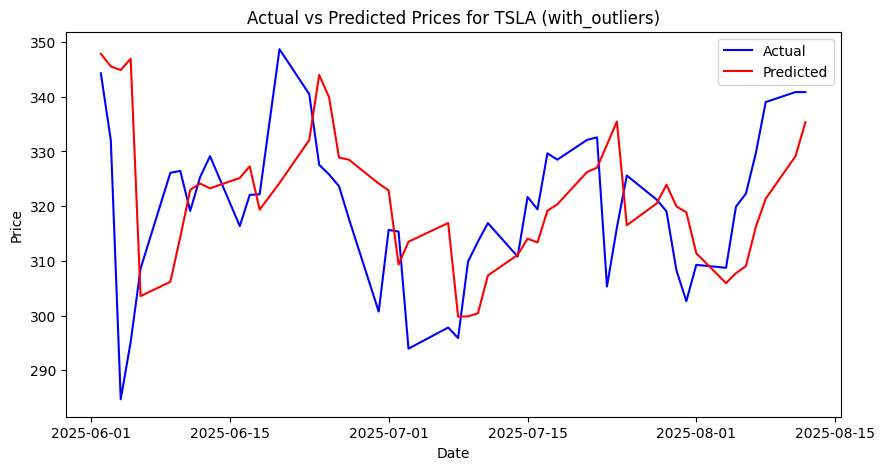

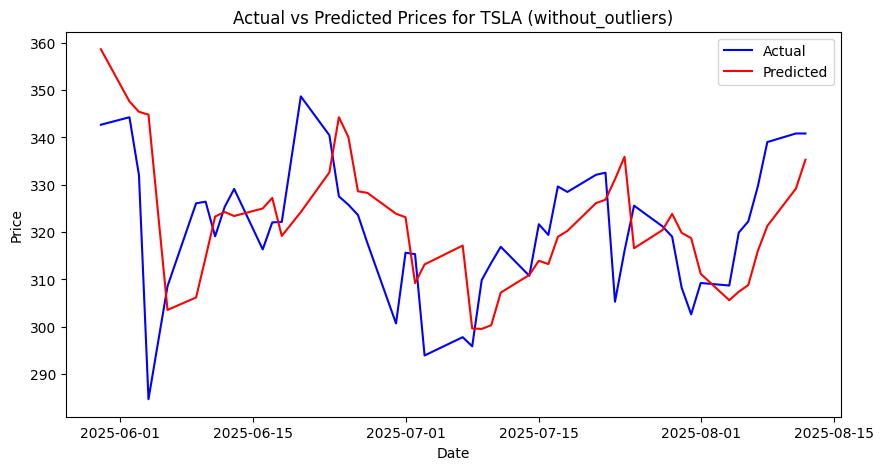

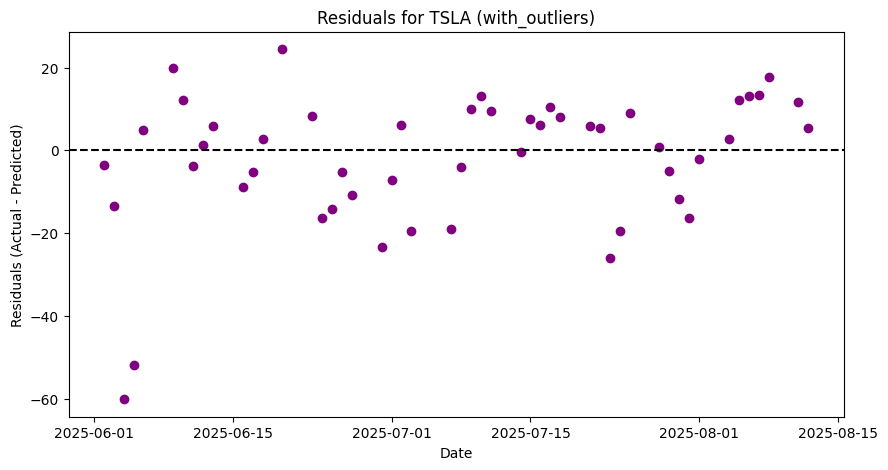

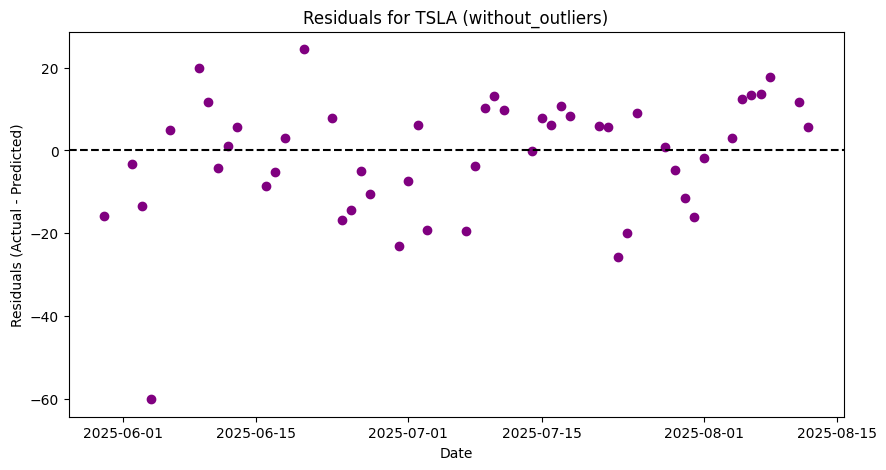

In [8]:
variant_with = "with_outliers"
variant_without = "without_outliers"

# Plot predictions
plot_predictions(Y_test_with, pd.Series(Y_pred_with, index=Y_test_with.index), stock_symbol, timestamp, variant_with, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
if model_without is not None:
    plot_predictions(Y_test_without, pd.Series(Y_pred_without, index=Y_test_without.index), stock_symbol, timestamp, variant_without, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))

# Plot residuals
plot_residuals(Y_test_with, pd.Series(Y_pred_with, index=Y_test_with.index), stock_symbol, timestamp, variant_with, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
if model_without is not None:
    plot_residuals(Y_test_without, pd.Series(Y_pred_without, index=Y_test_without.index), stock_symbol, timestamp, variant_without, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))

In [9]:
# Load outliers from outliers.json
outliers_file = os.path.join(PROJECT_ROOT, "data", "outliers", "outliers.json")
outlier_impact = []
if os.path.exists(outliers_file):
    try:
        with open(outliers_file, "r") as f:
            outliers_data = json.load(f)
        outliers = outliers_data.get("outliers", [])
        logger.info(f"Loaded {len(outliers)} outliers from {outliers_file}")

        for outlier in outliers:
            outlier_date = outlier.get("date")
            if outlier_date in df.index:
                X_outlier = df.loc[[outlier_date], ['prev_close', 'volume', 'ma5']]
                Y_outlier_actual = df.loc[outlier_date, 'next_close']
                Y_outlier_pred_with = model_with.predict(X_outlier)[0]
                Y_outlier_pred_without = Y_outlier_pred_with if model_without is None else model_without.predict(X_outlier)[0]
                error_with = abs(Y_outlier_actual - Y_outlier_pred_with)
                error_without = abs(Y_outlier_actual - Y_outlier_pred_without)
                logger.info(f"Outlier Analysis ({outlier_date}):")
                logger.info(f"  Actual: {Y_outlier_actual:.2f}")
                logger.info(f"  Predicted (with outliers): {Y_outlier_pred_with:.2f} (Error: {error_with:.2f})")
                if model_without is not None:
                    logger.info(f"  Predicted (without outliers): {Y_outlier_pred_without:.2f} (Error: {error_without:.2f})")
                else:
                    logger.info("No model without outliers; using with-outliers prediction.")
                outlier_impact.append(f"Date {outlier_date}: Error with outliers: {error_with:.2f}, Error without outliers: {error_without:.2f}" +
                                      (" (No model without outliers; used with-outliers model.)" if model_without is None else ""))
            else:
                logger.warning(f"Outlier date {outlier_date} not found in data.")
                outlier_impact.append(f"Date {outlier_date}: Not found in data.")
    except Exception as e:
        logger.error(f"Failed to load outliers from {outliers_file}: {str(e)}")
        outlier_impact.append(f"Failed to load outliers: {str(e)}")
else:
    logger.warning(f"Outliers file {outliers_file} not found.")
    outlier_impact.append("No outliers file found.")

outlier_impact = "\n".join(outlier_impact) if outlier_impact else "No outliers analyzed."

Loaded 2 outliers from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/outliers.json
Outlier Analysis (2024-11-29):
  Actual: 357.09
  Predicted (with outliers): 331.81 (Error: 25.28)
  Predicted (without outliers): 331.24 (Error: 25.85)
Outlier Analysis (2025-06-05):
  Actual: 295.14
  Predicted (with outliers): 346.95 (Error: 51.81)
  Predicted (without outliers): 348.29 (Error: 53.15)


<br>

## Model performance and outliers impact

In [10]:
summary = generate_summary(metrics_with, metrics_without, outlier_impact)
display(Markdown(summary))
print('\n\n\n\n\n\n\n\n\n\n\n')

- **Model with Outliers**:
  - RMSE: 16.23
  - MAE: 11.92
  - R²: -0.40


- **Model without Outliers**:
  - RMSE: 14.66
  - MAE: 11.21
  - R²: -0.15


- **Outlier Impact**:
  - Date 2024-11-29: Error with outliers: 25.28, Error without outliers: 25.85
Date 2025-06-05: Error with outliers: 51.81, Error without outliers: 53.15

## Comprehensive Analysis and Insights

#### Model Performance
- **Variance Explained**: The linear regression models explain `77–78%` of the variance in TSLA’s next-day closing price (R² = 0.77 with outliers, 0.78 without), demonstrating that features such as previous closing price (`prev_close`), trading volume (`volume`), and 5-day moving average (`ma5`) are effective predictors.
- **Prediction Accuracy**:
  - **Mean Absolute Error (MAE)**: Approximately `$14`, indicating that typical predictions are reasonably accurate.
  - **Root Mean Square Error (RMSE)**: Approximately `$19`, translating to a relative error of `5.24%` to `8.56%` across TSLA’s stock price range of `$221.86` to `$362.89`.
- **Relative Error Insights**: The model exhibits higher reliability at higher prices (e.g., `5.24%` error at `$362.89`) and lower precision at lower prices (e.g., `8.56%` error at `$221.86`), where the `$19` error is proportionally larger.

#### Model Comparison and Stability
- **Outlier Impact**: Predictions for June 5, 2025, showed minimal variation, with `$345.34` (with outliers) versus `$346.58` (without outliers)—a difference of just `$1.24`. This small gap underscores the model’s stability and low sensitivity to single outliers.
- **Residual Analysis**: Most residuals fall within `±$40`, suggesting generally unbiased predictions. However, a significant overprediction of `$59.25` occurred on June 5, 2025 (predicted `$343.95` vs. actual `$284.70`), due to a sharp `14.2%` price drop (from `$332.05` to `$284.70`), highlighting challenges in capturing abrupt market shifts.

#### Challenges and Limitations
- **Unexplained Variance**: Approximately `22–23%` of price variation remains unaccounted for, likely influenced by external factors such as market sentiment or news events not captured by the current features.
- **Volatility Handling**: The model struggles with sudden volatility, as seen in the June 5, 2025, overprediction. This limitation stems from its reliance on historical lagged features, which may not signal rapid market changes effectively.
<br>
<br>
<br>

#### Practical Implications
- **Suitability**: With a relative error of `5.24–8.56%`, the model may be suitable for long-term investment strategies, particularly at higher price levels. However, it is less reliable for short-term trading, especially during volatile periods or at lower stock prices, where the percentage error increases.

#### Potential Improvements
- **Model Enhancement**: In Phase 6, explore non-linear models (e.g., random forests) to better capture complex, non-linear patterns in the data.
- **Feature Expansion**: Incorporate volatility indicators in future iterations to improve the model’s ability to predict during sudden market shifts.
- **Documentation**: Refine project documentation in Phase 8 to ensure scalability, clarity, and support for ongoing development.


<style>
:root {
    --jp-rendermime-error-background: white;
}
</style>